# Introduction:
Setting up the environment for the project to be run

In [3]:
!nvidia-smi

Thu Mar  6 22:30:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install -q gdown inference-gpu
!pip install -q git+https://github.com/roboflow/sports.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.1/994.1 kB 17.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.6 MB/s eta 0:00:00


In [5]:
# !gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
# !gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
# !gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
# !gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /kaggle/working/121364_0.mp4
100%|██████████████████████████████████████| 17.2M/17.2M [00:00<00:00, 33.1MB/s]


In [6]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]" 
# Telling ONX which execution provider to use [in this case its CUDA].

In [9]:
import io
import sys
import cv2
import umap
import torch
import numpy as np
import supervision as sv

from inference import get_model
from kaggle_secrets import UserSecretsClient
from google.colab import userdata 
from tqdm import tqdm
from more_itertools import chunked # To make batches of data
from sklearn.cluster import KMeans
from typing import Optional
from transformers import AutoProcessor, SiglipVisionModel
from sports.common.team import TeamClassifier
from sports.common.view import ViewTransformer
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[clip]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration d

In [10]:
SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"
TARGET_VIDEO_PATH = "/kaggle/working/121364_0_result.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
STRIDE = 30

In [11]:
user_secrets = UserSecretsClient()
ROBOFLOW_API_KEY = user_secrets.get_secret("Roboflow")

# Object Detection & Team Classification:


In [12]:
DETECTION_MODEL_ID = "football-detection-ysgxf/3"
DETECTION_MODEL = get_model(
    model_id=DETECTION_MODEL_ID, 
    api_key=ROBOFLOW_API_KEY
)

In [13]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [14]:
def extract_crops(source_video_path: str):
    # Stride to skip every 29 frames and give us the 30th one
    frame_generator2 = sv.get_video_frames_generator(source_path=source_video_path, stride=STRIDE)
    crops = []
    for frame_sample in tqdm(frame_generator2, desc='collecting crops'):
        result = DETECTION_MODEL.infer(frame_sample, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops += [
            sv.crop_image(frame_sample, xyxy) 
            for xyxy 
            in detections.xyxy
        ]
    return crops

collecting crops: 25it [00:09,  2.51it/s]


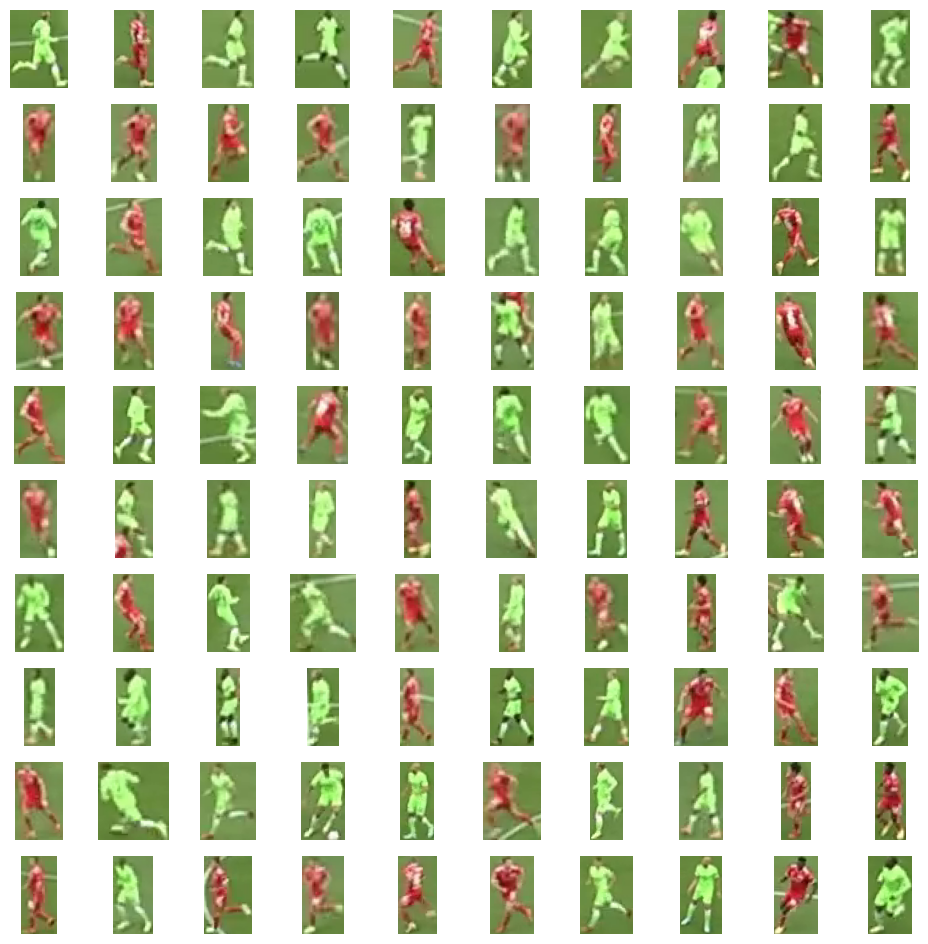

In [15]:
crops = extract_crops(SOURCE_VIDEO_PATH)
len('Number of crops:'+str(crops))
sv.plot_images_grid(crops[:100], grid_size=[10,10])

In [16]:
BATCH_SIZE = 32
# Converting from nump arrays (used by OpenCV which is used by Supervision) to pillow for SigLIP Model.
crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad(): # So model does not find gradient(not in training mode).
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data) # Last layer has higher dimensions so avg out to get the 768 vector.
data.shape

embedding extraction: 15it [00:06,  2.37it/s]


(478, 768)

In [17]:
REDUCER = umap.UMAP(n_components=3) # Reduce to 3D Space.
CLUSTERING_MODEL = KMeans(n_clusters=2)
projections = REDUCER.fit_transform(data)
projections.shape

(478, 3)

In [18]:
clusters = CLUSTERING_MODEL.fit_predict(projections)
clusters[:]

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,

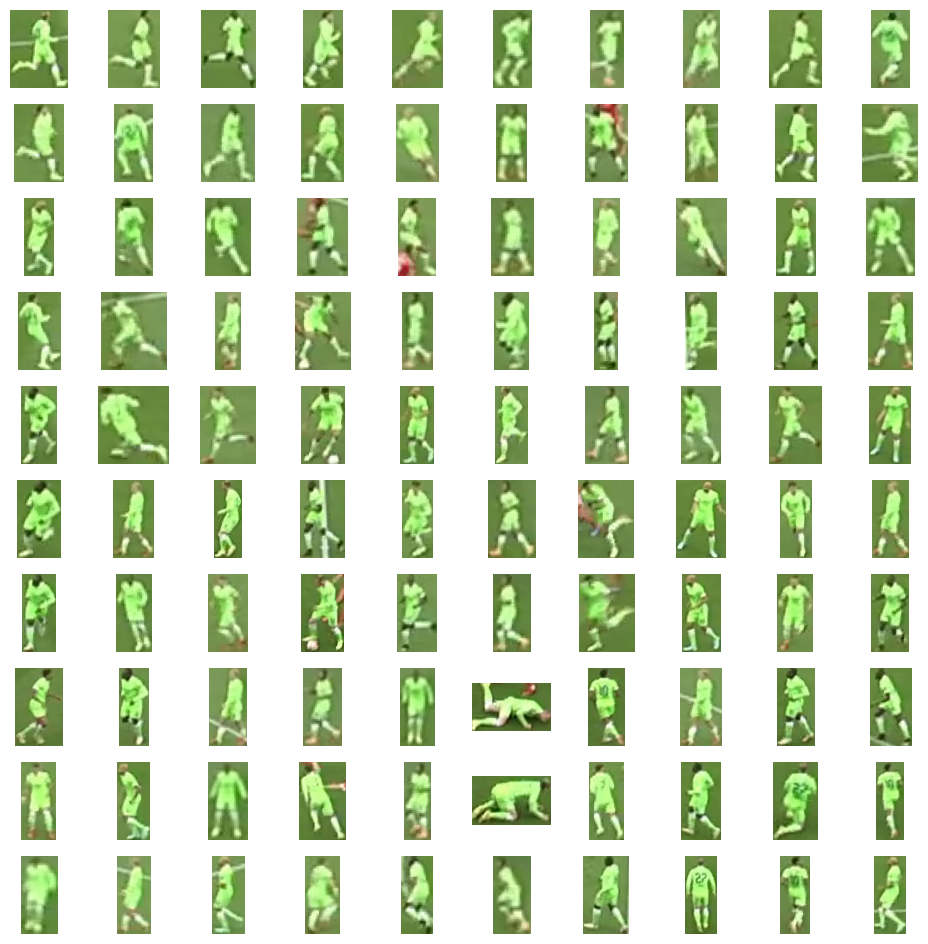

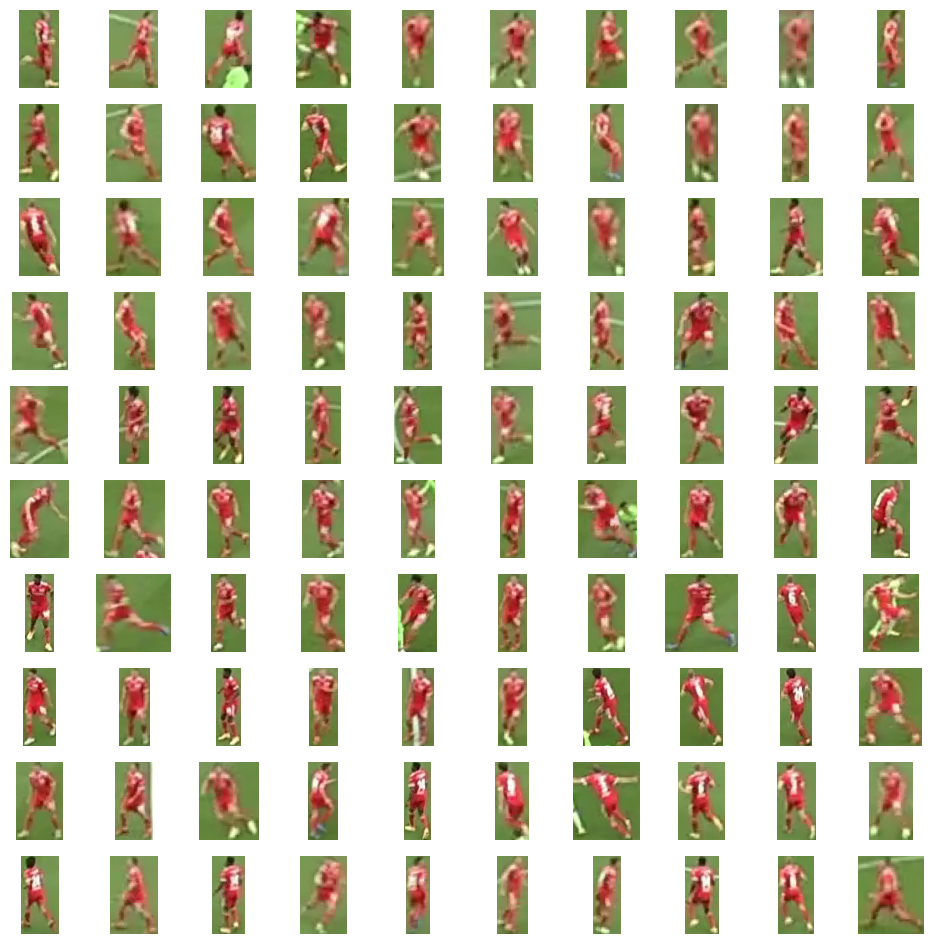

In [19]:
team_0 = [
    crop for crop, cluster
    in zip(crops, clusters)
    if cluster == 0
]
team_1 = [
    crop for crop, cluster
    in zip(crops, clusters)
    if cluster == 1
]
sv.plot_images_grid(team_0[:100], grid_size=[10,10])
sv.plot_images_grid(team_1[:100], grid_size=[10,10])

In [22]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:10,  2.44it/s]
Embedding extraction: 18it [00:07,  2.53it/s]


In [23]:
def resolve_goalkeepers_team_id(players: sv.Detections,goalkeepers: sv.Detections) -> np.ndarray:
    
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        # See the distance between the two teams' centroid
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Embedding extraction: 1it [00:00,  4.05it/s]


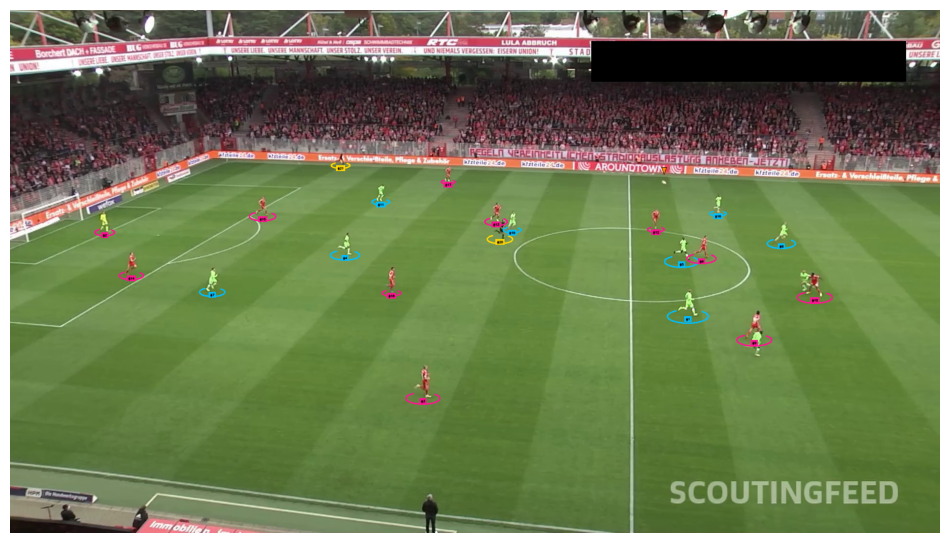

In [24]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00']),
    base = 10, 
    height= 15,
    outline_thickness=1
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

# Allows us to loop over frames of the video
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH) 
frame = next(frame_generator)

result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
other_detections = detections[detections.class_id != BALL_ID]

# Formatting detections:
# Increasing Ball Bounding box so traingle appears higher
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
# Adding Non-max Supressions to remove overlapping detections, regardless of whether they are from the same class or not
other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
# other_detections.class_id = other_detections.class_id - 1
other_detections = tracker.update_with_detections(detections=other_detections)

goalkeepers_detections = other_detections[other_detections.class_id == GOALKEEPER_ID]
players_detections = other_detections[other_detections.class_id == PLAYER_ID]
referees_detections = other_detections[other_detections.class_id == REFEREE_ID]


player_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(player_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

other_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in other_detections.tracker_id
]
other_detections.class_id = other_detections.class_id.astype(int)
annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=other_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=other_detections,
    labels=labels)

sv.plot_image(annotated_frame)

In [24]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00']),
    base = 15, 
    height= 17,
    outline_thickness=0
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

# Allows us to loop over frames of the video
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Keeping the same video attributes as the input video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        other_detections = detections[detections.class_id != BALL_ID]
        
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
        other_detections = tracker.update_with_detections(detections=other_detections)
        
        goalkeepers_detections = other_detections[other_detections.class_id == GOALKEEPER_ID]
        players_detections = other_detections[other_detections.class_id == PLAYER_ID]
        referees_detections = other_detections[other_detections.class_id == REFEREE_ID]
        
        
        player_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(player_crops)
        
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
            players_detections, goalkeepers_detections
        )
        
        referees_detections.class_id -= 1
        
        other_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])
        
        other_detections.class_id = other_detections.class_id.astype(int)
        
        labels = [
            f"#{tracker_id}"
            for tracker_id
            in other_detections.tracker_id
        ]
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=other_detections)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=other_detections,
            labels=labels)
        video_sink.write_frame(annotated_frame)

sv.plot_image(annotated_frame)

  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.17it/s]
  0%|          | 1/750 [00:00<08:48,  1.42it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.08it/s]
  0%|          | 2/750 [00:01<07:57,  1.57it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.29it/s]
  0%|          | 3/750 [00:01<07:29,  1.66it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.25it/s]
  1%|          | 4/750 [00:02<07:16,  1.71it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.00it/s]
  1%|          | 5/750 [00:02<07:13,  1.72it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.08it/s]
  1%|          | 6/750 [00:03<07:10,  1.73it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.02it/s]
  1%|          | 7/750 [00:04<07:09,  1.73it/s]
Embedding extraction: 

KeyboardInterrupt: 

In [25]:
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi-jufj9/1"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

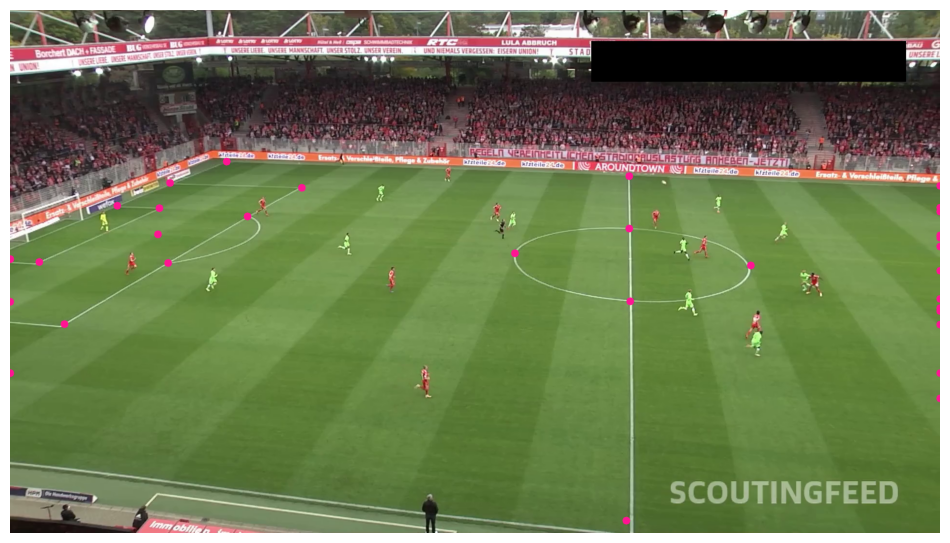

In [26]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

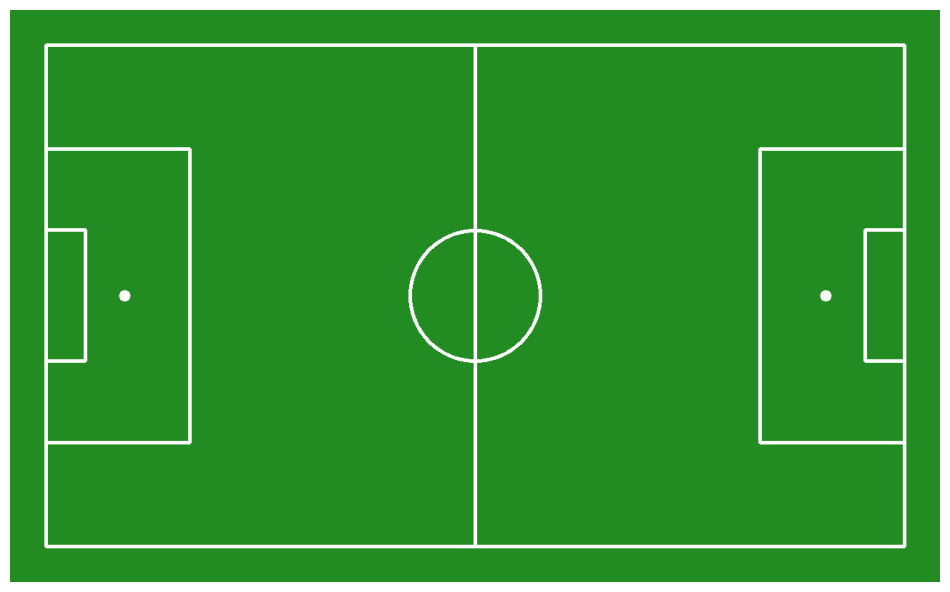

In [27]:
CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

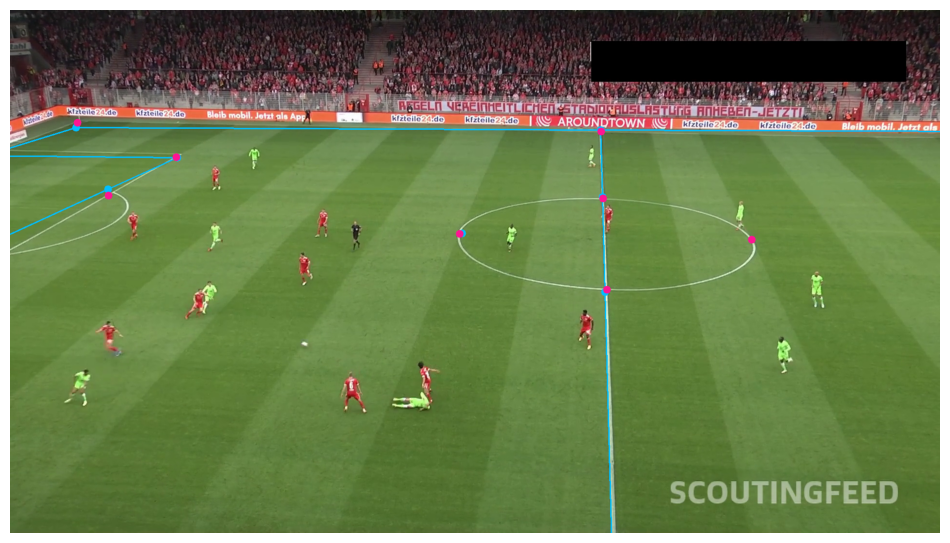

In [28]:
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

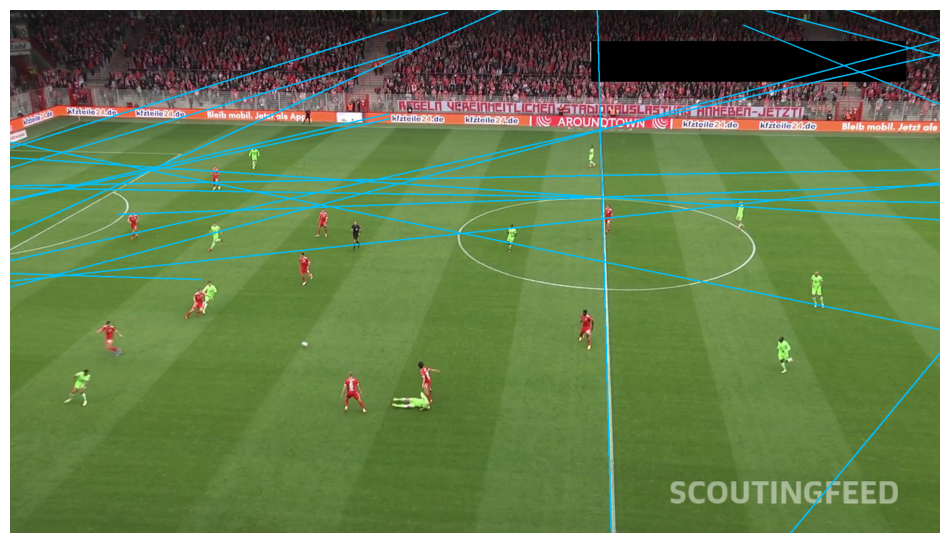

In [29]:
import numpy as np
import cv2
# import supervision as sv  # assuming supervision is imported as sv

# --- Helper Functions ---
def extend_line(p1, p2, extension=1000):
    """
    Extend the line defined by p1 and p2 by a given extension distance in both directions.
    """
    p1 = np.array(p1, dtype=np.float32)
    p2 = np.array(p2, dtype=np.float32)
    direction = p2 - p1
    norm = np.linalg.norm(direction)
    if norm == 0:
        return tuple(p1), tuple(p2)
    direction = direction / norm
    new_p1 = p1 - extension * direction
    new_p2 = p2 + extension * direction
    return tuple(new_p1), tuple(new_p2)

def line_intersection(p1, p2, p3, p4):
    """
    Compute the intersection point of two lines defined by (p1, p2) and (p3, p4).
    Returns (x, y) or None if the lines are parallel.
    """
    x1, y1 = p1; x2, y2 = p2
    x3, y3 = p3; x4, y4 = p4

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if np.isclose(denom, 0):
        return None  # Lines are parallel or coincident
    x = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / denom
    y = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / denom
    return (x, y)

# --- Extended Edge Annotator ---
class ExtendedEdgeAnnotator(sv.EdgeAnnotator):
    def __init__(self, extension=1000, **kwargs):
        """
        extension: The number of pixels by which to extend each line in both directions.
        kwargs: Other parameters passed to the base EdgeAnnotator (e.g., color, thickness, edges).
        """
        super().__init__(**kwargs)
        self.extension = extension

    def annotate(self, scene: np.ndarray, key_points: sv.KeyPoints) -> np.ndarray:
        """
        Override the annotate method to draw extended lines.
        """
        for edge in self.edges:
            idx1, idx2 = edge
            p1 = key_points.xy[0][idx1]
            p2 = key_points.xy[0][idx2]
            # Compute extended endpoints
            extended_p1, extended_p2 = extend_line(p1, p2, extension=self.extension)
            # Draw the extended line using the color and thickness settings
            cv2.line(
                scene,
                (int(extended_p1[0]), int(extended_p1[1])),
                (int(extended_p2[0]), int(extended_p2[1])),
                self.color.as_bgr(),
                self.thickness
            )
        return scene

# --- Pipeline Integration ---
# Create an instance of the extended annotator (adjust extension as needed)
extended_edge_annotator = ExtendedEdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2,
    edges=CONFIG.edges,  # using your CONFIG.edges
    extension=1000
)

# Process a frame as before (assumes frame_all_points and frame_all_key_points have been computed)
annotated_frame = frame.copy()
annotated_frame = extended_edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points
)

# --- Intersection Calculation ---
# Here we select two edges (e.g. the half-line and the D-box horizontal line).
# Adjust the indices as needed based on your pitch layout.
edge1 = CONFIG.edges[0]  # e.g. half line
edge2 = CONFIG.edges[1]  # e.g. D-box horizontal line

# Retrieve the original transformed keypoints for these edges.
p1 = frame_all_points[edge1[0]]
p2 = frame_all_points[edge1[1]]
p3 = frame_all_points[edge2[0]]
p4 = frame_all_points[edge2[1]]

# Extend these lines
extended_p1, extended_p2 = extend_line(p1, p2, extension=1000)
extended_p3, extended_p4 = extend_line(p3, p4, extension=1000)

# Compute the intersection between the two extended lines
intersection_point = line_intersection(extended_p1, extended_p2, extended_p3, extended_p4)

# Annotate the intersection point on the frame if it exists.
if intersection_point is not None:
    cv2.circle(
        annotated_frame,
        (int(intersection_point[0]), int(intersection_point[1])),
        8,
        (0, 255, 0),  # Green circle for the intersection
        -1
    )

# Finally, plot the annotated frame.
sv.plot_image(annotated_frame)


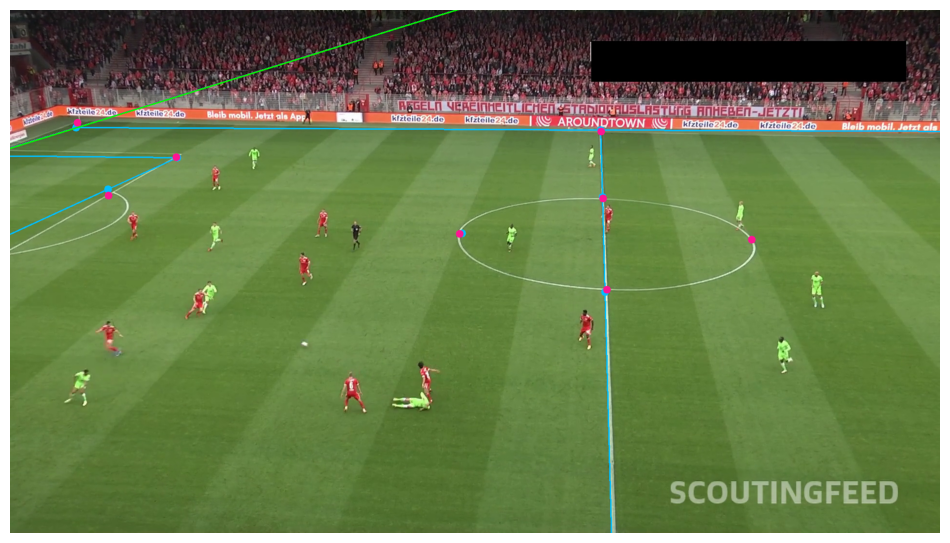

In [30]:
import numpy as np
import cv2
import supervision as sv

# --- Helper Functions ---
def extend_line(p1, p2, extension=1000):
    """
    Extend the line defined by p1 and p2 by a given extension distance in both directions.
    """
    p1 = np.array(p1, dtype=np.float32)
    p2 = np.array(p2, dtype=np.float32)
    direction = p2 - p1
    norm = np.linalg.norm(direction)
    if norm == 0:
        return tuple(p1), tuple(p2)  # Avoid division by zero
    direction = direction / norm
    new_p1 = p1 - extension * direction
    new_p2 = p2 + extension * direction
    return tuple(new_p1), tuple(new_p2)

def line_intersection(p1, p2, p3, p4):
    """
    Compute the intersection point of two lines defined by (p1, p2) and (p3, p4).
    Returns (x, y) or None if the lines are parallel.
    """
    x1, y1 = p1; x2, y2 = p2
    x3, y3 = p3; x4, y4 = p4

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if np.isclose(denom, 0):
        return None  # Lines are parallel or coincident
    x = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / denom
    y = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / denom
    return (x, y)

# --- Annotators ---
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8
)

# --- Load Frame and Process Keypoints ---
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...]
)

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

# --- Annotate Base Pitch ---
annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points
)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points
)

# --- Extend Only Specific Key Lines ---
# Adjust these indices based on your CONFIG.edges structure
half_line = CONFIG.edges[0]  # Example: Half-line
d_box_line = CONFIG.edges[1]  # Example: D-box horizontal line
pitch_boundary = CONFIG.edges[2]  # Example: Pitch boundary

# Get transformed points for these lines
p1, p2 = frame_all_points[half_line[0]], frame_all_points[half_line[1]]
p3, p4 = frame_all_points[d_box_line[0]], frame_all_points[d_box_line[1]]
p5, p6 = frame_all_points[pitch_boundary[0]], frame_all_points[pitch_boundary[1]]

# Extend the lines
extended_p1, extended_p2 = extend_line(p1, p2, extension=2000)
extended_p3, extended_p4 = extend_line(p3, p4, extension=2000)
extended_p5, extended_p6 = extend_line(p5, p6, extension=2000)

# Draw extended lines
cv2.line(annotated_frame, tuple(map(int, extended_p1)), tuple(map(int, extended_p2)), (0, 191, 255), 2)  # Half-line
cv2.line(annotated_frame, tuple(map(int, extended_p3)), tuple(map(int, extended_p4)), (255, 20, 147), 2)  # D-box line
cv2.line(annotated_frame, tuple(map(int, extended_p5)), tuple(map(int, extended_p6)), (0, 255, 0), 2)  # Pitch boundary

# --- Find Intersection ---
intersection_1 = line_intersection(extended_p1, extended_p2, extended_p3, extended_p4)
intersection_2 = line_intersection(extended_p1, extended_p2, extended_p5, extended_p6)
intersection_3 = line_intersection(extended_p3, extended_p4, extended_p5, extended_p6)

# Average intersection if multiple lines intersect
intersections = [pt for pt in [intersection_1, intersection_2, intersection_3] if pt is not None]
if intersections:
    avg_intersection = np.mean(intersections, axis=0).astype(int)
    cv2.circle(annotated_frame, tuple(avg_intersection), 10, (0, 255, 255), -1)  # Yellow for intersection

# --- Show Result ---
sv.plot_image(annotated_frame)


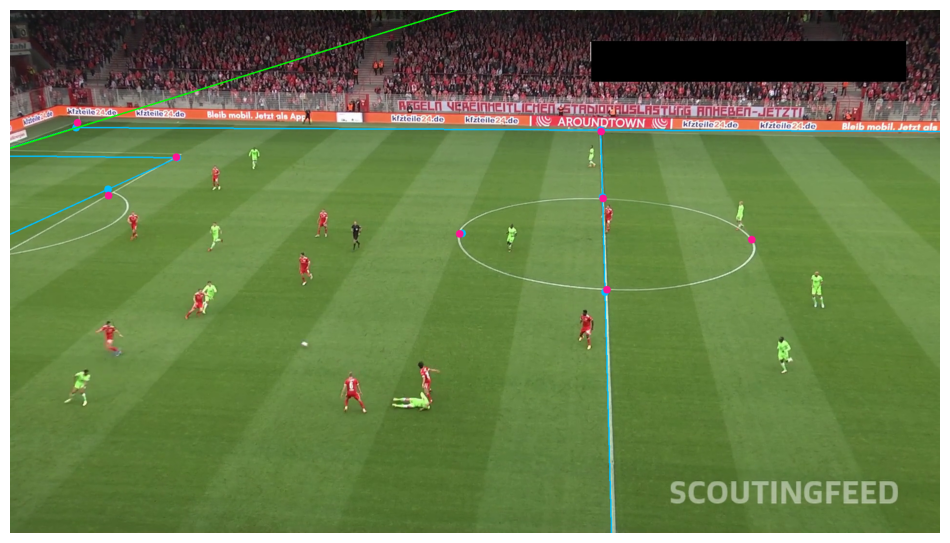

In [32]:
import numpy as np
import cv2
import supervision as sv

# --- Helper Functions ---
def extend_line(p1, p2, extension=2000):
    """
    Extend the line defined by p1 and p2 by a given extension distance in both directions.
    """
    p1, p2 = np.array(p1, dtype=np.float32), np.array(p2, dtype=np.float32)
    direction = p2 - p1
    norm = np.linalg.norm(direction)
    if norm == 0:
        return tuple(p1), tuple(p2)  # Avoid division by zero
    direction /= norm
    return tuple(p1 - extension * direction), tuple(p2 + extension * direction)

def line_intersection(p1, p2, p3, p4):
    """
    Compute the intersection point of two lines defined by (p1, p2) and (p3, p4).
    Returns (x, y) or None if the lines are parallel.
    """
    x1, y1 = p1; x2, y2 = p2
    x3, y3 = p3; x4, y4 = p4

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if np.isclose(denom, 0):
        return None  # Lines are parallel or coincident
    x = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / denom
    y = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / denom
    return (x, y)

# --- Annotators ---
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8
)

# --- Load Frame and Process Keypoints ---
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...]
)

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

# --- Annotate Base Pitch ---
annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points
)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points
)

# --- Extend Specific Key Lines ---
# Ensure the correct indices are selected for each line
half_line = CONFIG.edges[0]  # Adjust index if incorrect
d_box_line = CONFIG.edges[1]  # Adjust index if incorrect
pitch_width_border = CONFIG.edges[2]  # Adjust index if incorrect

# Transform key lines into the frame coordinates
p1, p2 = frame_all_points[half_line[0]], frame_all_points[half_line[1]]
p3, p4 = frame_all_points[d_box_line[0]], frame_all_points[d_box_line[1]]
p5, p6 = frame_all_points[pitch_width_border[0]], frame_all_points[pitch_width_border[1]]

# Extend each line properly
extended_p1, extended_p2 = extend_line(p1, p2, extension=3000)  # Half-line
extended_p3, extended_p4 = extend_line(p3, p4, extension=3000)  # D-box horizontal line
extended_p5, extended_p6 = extend_line(p5, p6, extension=3000)  # Pitch width border

# Draw extended lines
cv2.line(annotated_frame, tuple(map(int, extended_p1)), tuple(map(int, extended_p2)), (0, 191, 255), 2)  # Half-line
cv2.line(annotated_frame, tuple(map(int, extended_p3)), tuple(map(int, extended_p4)), (255, 20, 147), 2)  # D-box line
cv2.line(annotated_frame, tuple(map(int, extended_p5)), tuple(map(int, extended_p6)), (0, 255, 0), 2)  # Pitch width border

# --- Find Intersections ---
intersection_1 = line_intersection(extended_p1, extended_p2, extended_p3, extended_p4)
intersection_2 = line_intersection(extended_p1, extended_p2, extended_p5, extended_p6)
intersection_3 = line_intersection(extended_p3, extended_p4, extended_p5, extended_p6)

# Compute final intersection point
intersections = [pt for pt in [intersection_1, intersection_2, intersection_3] if pt is not None]
if intersections:
    avg_intersection = np.mean(intersections, axis=0).astype(int)
    cv2.circle(annotated_frame, tuple(avg_intersection), 10, (0, 255, 255), -1)  # Yellow for intersection

# --- Show Result ---
sv.plot_image(annotated_frame)


In [29]:
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:10,  2.41it/s]
Embedding extraction: 18it [00:07,  2.36it/s]


In [30]:
def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

Embedding extraction: 1it [00:00,  4.00it/s]


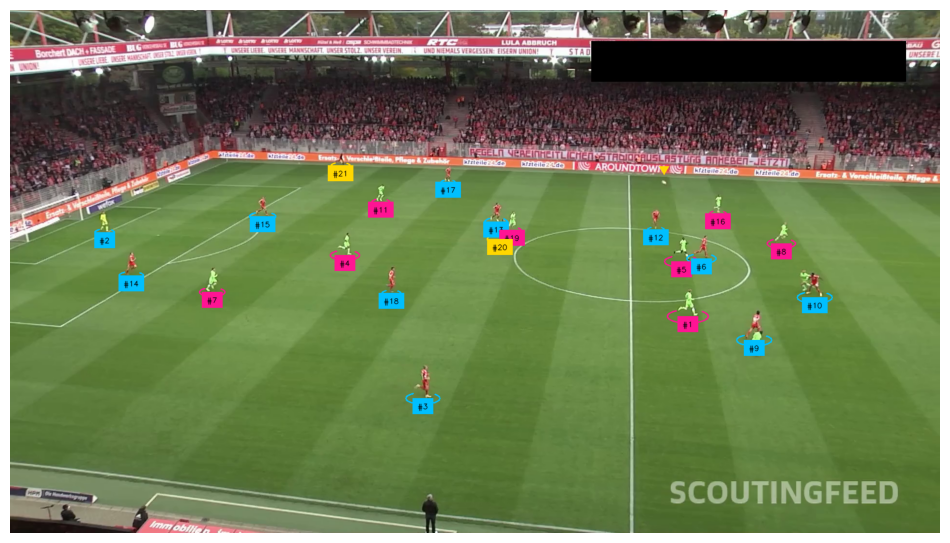

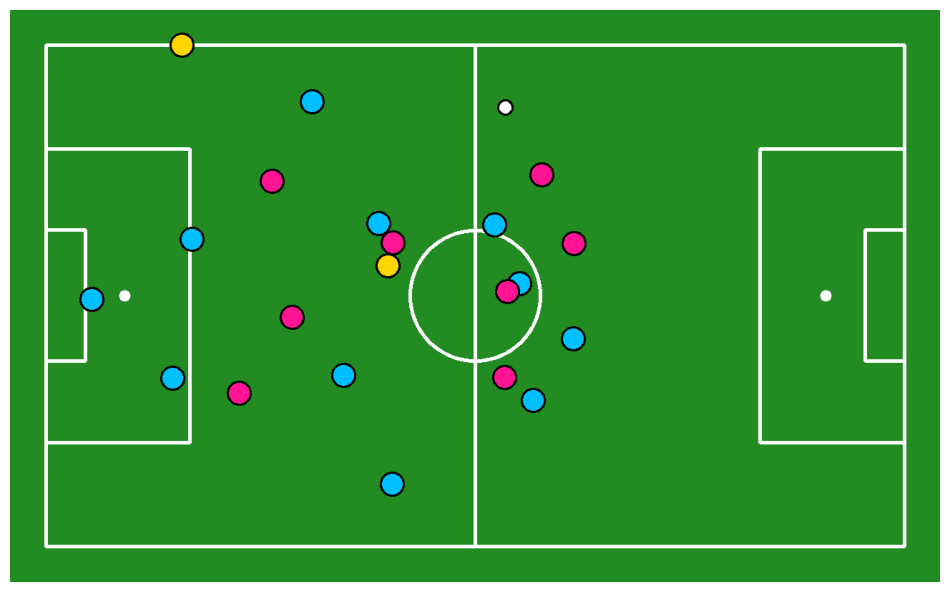

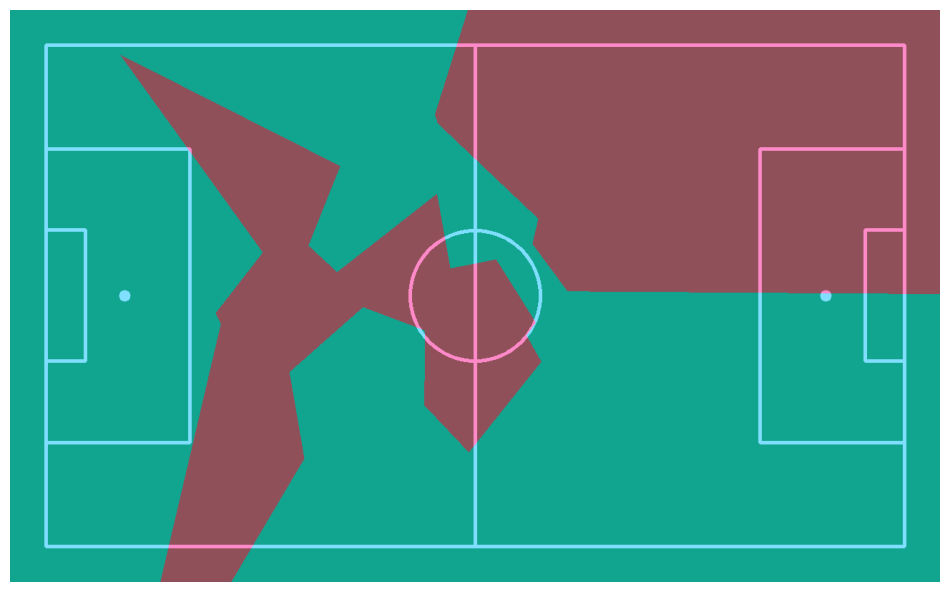

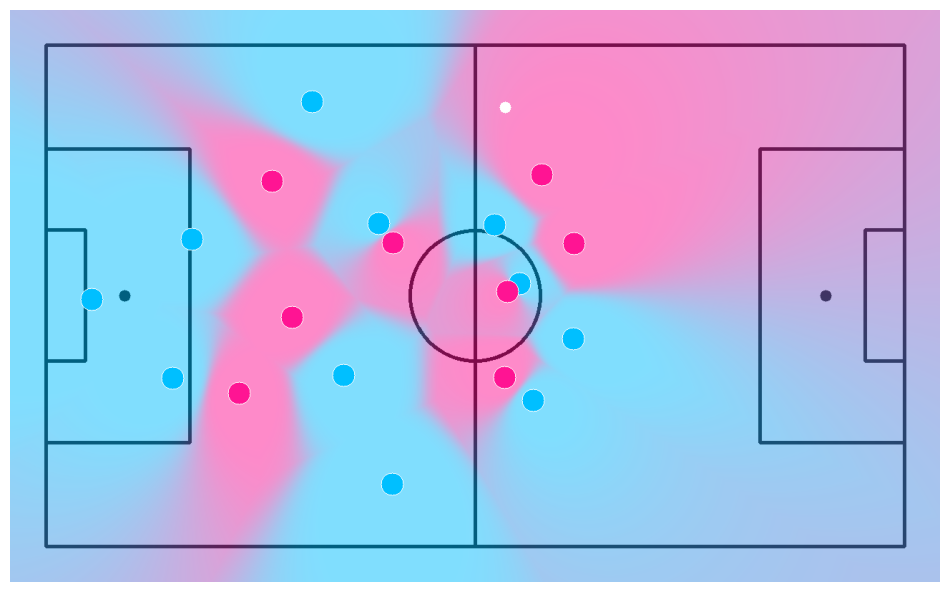

In [31]:
SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# visualize video game-style radar view

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram with blend

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [37]:
OUTPUT_VIDEO_PATH = "output_video.mp4"
TARGET_VIDEO_PATH = "result5.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

CONFIG = SoccerPitchConfiguration()

pitch_frame = draw_pitch(CONFIG)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
fps = 30
frame_height, frame_width = pitch_frame.shape[:2]
# Keeping the same video attributes as the input video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink1 = sv.VideoSink("/kaggle/working/sink1.mp4", video_info=video_info)
video_writer1 = cv2.VideoWriter('/kaggle/working/output_video1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps,(frame_width, frame_height))
video_writer2 = cv2.VideoWriter('/kaggle/working/output_video2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps,(frame_width, frame_height)) 
video_writer3 = cv2.VideoWriter('/kaggle/working/output_video3.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height)) 

with video_sink1:
# Process each frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)
        
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
        
        # team assignment
        
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)
        
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
            players_detections, goalkeepers_detections)
        
        referees_detections.class_id -= 1
        
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections])
        
        # frame visualization
        
        labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]
        
        all_detections.class_id = all_detections.class_id.astype(int)
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections,
            labels=labels)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections)
        
        video_sink1.write_frame(annotated_frame)
        
        players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])
        
        # detect pitch key points
        
        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)
        
        # project ball, players and referies on pitch
        
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG.vertices)[filter]
        
        transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )
        
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)
        
        players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = transformer.transform_points(points=players_xy)
        
        referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = transformer.transform_points(points=referees_xy)
        
        # visualize video game-style radar view
        
        annotated_frame = draw_pitch(CONFIG)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_referees_xy,
            face_color=sv.Color.from_hex('FFD700'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame)
        
        # video_sink1.write_frame(annotated_frame)
        video_writer1.write(annotated_frame)
        
        # visualize voronoi diagram
        
        annotated_frame = draw_pitch(CONFIG)
        annotated_frame = draw_pitch_voronoi_diagram(
            config=CONFIG,
            team_1_xy=pitch_players_xy[players_detections.class_id == 0],
            team_2_xy=pitch_players_xy[players_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_frame)
        
        # video_sink2.write_frame(annotated_frame)
        video_writer2.write(annotated_frame)
        
        
        # visualize voronoi diagram with blend
        
        annotated_frame = draw_pitch(
            config=CONFIG,
            background_color=sv.Color.WHITE,
            line_color=sv.Color.BLACK
        )
        annotated_frame = draw_pitch_voronoi_diagram_2(
            config=CONFIG,
            team_1_xy=pitch_players_xy[players_detections.class_id == 0],
            team_2_xy=pitch_players_xy[players_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.WHITE,
            radius=8,
            thickness=1,
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_frame)
        
        # video_sink3.write_frame(annotated_frame)
        video_writer3.write(annotated_frame)

video_writer1.release()
video_writer2.release()
video_writer3.release()


  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.25it/s]
  0%|          | 1/750 [00:01<15:54,  1.27s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.22it/s]
  0%|          | 2/750 [00:02<15:12,  1.22s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.29it/s]
  0%|          | 3/750 [00:03<14:48,  1.19s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.35it/s]
  1%|          | 4/750 [00:04<14:35,  1.17s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.08it/s]
  1%|          | 5/750 [00:05<14:36,  1.18s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.15it/s]
  1%|          | 6/750 [00:07<14:35,  1.18s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.21it/s]
  1%|          | 7/750 [00:08<14:32,  1.17s/it]
Embedding extraction: 